In [2]:
import numpy as np

roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])
        
last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


In [3]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [4]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [5]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [6]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


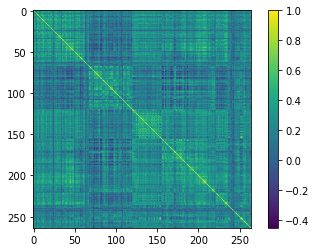

In [155]:
def rearrange(p,idcs):
    return p[:,idcs,:][:,:,idcs]

plt.imshow(rearrange(nback_p[0:2], revMap2)[1])
plt.colorbar()
plt.show()

In [156]:
def rearrange(p,idcs):
    return p[:,idcs,:][:,:,idcs]

def convertLow(p, borders1):
    n = len(borders1)-1
    lowRes = np.zeros((p.shape[0],n,n))
#     p = p*np.expand_dims(1-np.eye(p.shape[1]),axis=0)
    for i in range(n):
        for j in range(n):
            i0 = borders1[i]
            i1 = borders1[i+1]
            j0 = borders1[j]
            j1 = borders1[j+1]
            lowRes[:,i,j] = np.mean(p[:,i0:i1,j0:j1], axis=(1,2))
    return lowRes
    
nback_p_low = convertLow(rearrange(nback_p, revMap2), borders1)
emoid_p_low = convertLow(rearrange(emoid_p, revMap2), borders1)

print('Complete')

Complete


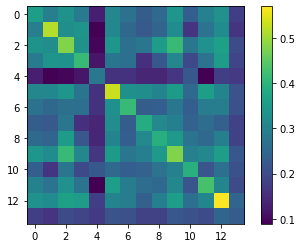

In [158]:
import matplotlib.pyplot as plt

plt.imshow(nback_p_low[1])
plt.colorbar()
plt.show()

In [167]:
import torch

def convertTorch(p, sz, offset):
    idx, idy = torch.triu_indices(sz,sz,offset=offset)
    u = torch.zeros(p.shape[0],idx.shape[0])
    u = torch.from_numpy(p).float()[:,idx,idy]
    return u.cuda()

def convertTorchBack(p, sz, offset):
    idx, idy = torch.triu_indices(sz,sz,offset=offset)
    if p.dim() == 1:
        p = p.unsqueeze(0)
    u = torch.zeros(p.shape[0],sz,sz).float().cuda()
    u[:,idx,idy] = p
    u = u + u.permute(0,2,1) - u*torch.eye(sz).float().cuda().unsqueeze(0)
    if u.shape[0] == 1:
        u = u.squeeze(0)
    return u.detach().cpu()

nback_p_t = convertTorch(nback_p_low,14,0)
emoid_p_t = convertTorch(emoid_p_low,14,0)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 105])
torch.Size([620, 105])
Complete


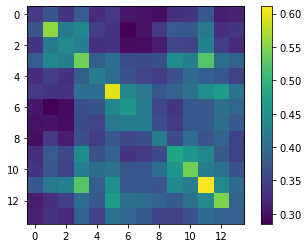

In [65]:
plt.imshow(convertTorchBack(nback_p_t[0],14,0))
plt.colorbar()
plt.show()

In [173]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print('Norm complete')

Norm complete


In [174]:
print(torch.min(nback_p_t[:,0:5],dim=0))
print(torch.min(emoid_p_t[:,0:5],dim=0))

torch.return_types.min(
values=tensor([-2.0503, -2.4398, -2.1676, -2.2232, -1.9544], device='cuda:0'),
indices=tensor([611, 605, 546, 605, 605], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.5705, -2.1666, -2.1041, -2.1162, -2.3131], device='cuda:0'),
indices=tensor([  3, 563, 339, 216, 392], device='cuda:0'))


In [71]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [72]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [185]:
import torch.nn as nn
import torch.nn.functional as F
import time

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, dp=0.5, dp2=0.1, method='same'):
        super(LatSim, self).__init__()
        self.nTgts = nTgts
        self.method = method
        self.masks = []
        if method == 'same':
            nMasks = nTgts
        elif method == 'diff':
            nMasks = 2*nTgts
        elif method == 'univ':
            nMasks = nTgts+1
        for i in range(nMasks):
            self.masks.append(nn.Parameter(
                1e-4*torch.randn(arith(14),2).float().cuda()
            ))
        self.masks = nn.ParameterList(self.masks)
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
        self.ln = nn.LayerNorm((nTgts, nback_p_t.shape[1])).cuda()
    
    def getLatentsAndEdges(self, x, i):
        if self.method == 'univ':
            y = torch.einsum('ac,ce->ae', x, self.masks[0])
            z = torch.einsum('ac,ce->ae', x, self.masks[i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'diff':
            y = torch.einsum('ac,ce->ae', x, self.masks[2*i])
            z = torch.einsum('ac,ce->ae', x, self.masks[2*i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'same':
            y = torch.einsum('ac,ce->ae', x, self.masks[i])
            e = y@y.T+1e-10
            return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(self.nTgts):
            nClass = y.shape[1] if y.dim() == 2 else 1
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
        
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 5000
pPeriod = 200
thresh = 500

para = [nback_p_t, emoid_p_t]
rmse = []
simMap = []
# mat = mats[0]

X = torch.stack(para, dim=1)

t = time.time()
for i in range(10):
    sim = LatSim(len(para), 0, 0, 'same')
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) # 1e-4 age, gender; 1e-5 wrat

    trainIdcs = groups[i][0][0:496][0:100]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    
    trainLoss = []
    validLoss = []
    
    vIdcs1 = np.arange(496,len(validIdcs))
    vIdcs2 = validIdcs[496:]
    vIdcs3 = np.concatenate([testIdcs, vIdcs2])

    var = age_t
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, _ = sim(Xt, var[trainIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        loss = mseLoss(avg, var[trainIdcs])
        for r in res:
            loss += mseLoss(r, var[trainIdcs])
        loss = torch.stack([loss/(len(res)+1)])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss))}')
            lossV = validate(sim, Xv, var[validIdcs], vIdcs1)
            if len(validLoss) == 0 or lossV < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
    loss = validate(sim, X, var, testIdcs)

    rmse.append((float(loss)))
        
    print(i, end=' ')
    print(rmse[-1])
    
    continue
    
    Y0 = torch.einsum('ab,bc->abc', nback_p_t, sim.masks[0])
    Y1 = torch.einsum('ab,bc->abc', emoid_p_t, sim.masks[1])

    print(Y0.shape)
    print(Y1.shape)

    idcs = torch.argsort(var) if var is age_t or var is wrt_t else torch.argsort(var[:,0])
    Y0sort = Y0[idcs,:,:]
    Y1sort = Y1[idcs,:,:]

    simMapPart = []
    step = 100

    for Y in [Y0sort, Y1sort]:
        parts = []
        for j in range(0,40000,step):
            if j >= Y.shape[1]:
                break
            part = Y[:,j:j+step,:]
            subConnSim = torch.einsum('abc,dbc->adb', part, part)
            subConnR = torch.einsum('adb,ad->b', subConnSim, mat)
            parts.append(subConnR.detach().cpu().numpy())

        parts = np.concatenate(parts)
        simMapPart.append(parts)

    simMap.append(np.stack(simMapPart))
    print('Complete')
    
print(time.time()-t)

epoch 0 loss=1704.76123046875
New best validation epoch 0 loss=44.58372497558594
epoch 200 loss=1485.8944091796875
New best validation epoch 200 loss=41.111534118652344
epoch 400 loss=1341.310546875
New best validation epoch 400 loss=40.566307067871094
epoch 600 loss=1181.624755859375
New best validation epoch 600 loss=39.95676040649414
epoch 800 loss=1039.75634765625
New best validation epoch 800 loss=39.48311233520508
epoch 1000 loss=928.5340576171875
New best validation epoch 1000 loss=39.235633850097656
epoch 1200 loss=845.0289916992188
New best validation epoch 1200 loss=39.13347244262695
epoch 1400 loss=780.626708984375
New best validation epoch 1400 loss=39.096343994140625
epoch 1600 loss=727.4237060546875
epoch 1800 loss=680.4466552734375
epoch 2000 loss=637.6451416015625
epoch 2200 loss=600.1505737304688
epoch 2400 loss=568.0515747070312
epoch 2600 loss=539.9310913085938
epoch 2800 loss=514.6600952148438
epoch 2925 loss=499.97235107421875
Early stopping
Finished training
0 34.

epoch 800 loss=1111.739501953125
New best validation epoch 800 loss=38.4415168762207
epoch 1000 loss=978.9864501953125
New best validation epoch 1000 loss=38.25593566894531
epoch 1200 loss=874.9737548828125
epoch 1400 loss=792.946533203125
epoch 1600 loss=726.7250366210938
epoch 1800 loss=672.822509765625
epoch 2000 loss=628.22509765625
epoch 2200 loss=590.0438842773438
epoch 2400 loss=556.3211669921875
epoch 2600 loss=525.954833984375
epoch 2788 loss=499.9034118652344
Early stopping
Finished training
8 29.823129653930664
epoch 0 loss=1535.080322265625
New best validation epoch 0 loss=44.9538688659668
epoch 200 loss=1356.4283447265625
New best validation epoch 200 loss=41.18077087402344
epoch 400 loss=1222.7061767578125
New best validation epoch 400 loss=40.4302978515625
epoch 600 loss=1075.94970703125
New best validation epoch 600 loss=39.62429428100586
epoch 800 loss=946.9166259765625
New best validation epoch 800 loss=39.00557327270508
epoch 1000 loss=845.7355346679688
New best vali

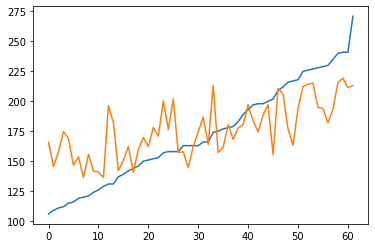

In [183]:
import matplotlib.pyplot as plt

res, _ = sim(X, var, testIdcs)
avg = torch.mean(torch.stack(res), dim=0)

idcs = torch.argsort(var[testIdcs])
avg = avg[testIdcs][idcs]

plt.plot(var[testIdcs][idcs].detach().cpu().numpy())
plt.plot(avg.detach().cpu().numpy())
plt.show()

In [186]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

34.35840606689453
39.4106330871582
33.39952850341797
32.48110580444336
36.03346252441406
35.151702880859375
35.80958557128906
34.0456657409668
29.823129653930664
36.595069885253906
---
34.710828971862796


In [168]:
rmse = []

for i in range(10):
    trainIdcs = groups[i][0][0:496][0:100]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]

    w0, res, _, _ = torch.linalg.lstsq(nback_p_t[trainIdcs], age_t[trainIdcs])
    w1, res, _, _ = torch.linalg.lstsq(emoid_p_t[trainIdcs], age_t[trainIdcs])

    r0 = nback_p_t[testIdcs]@w0
    r1 = emoid_p_t[testIdcs]@w1 

    loss = mseLoss((r0+r1)/2, age_t[testIdcs])**0.5
    rmse.append(float(loss))
    print(float(loss))
    
print('---')
print(sum(rmse)/len(rmse))

92.08345031738281
112.90229034423828
108.2409439086914
139.0281219482422
93.77735900878906
87.94331359863281
148.63072204589844
111.75794982910156
263.90911865234375
94.7371597290039
---
125.30104293823243


In [171]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv
import time

def arith(n):
    return int(n*(n+1)/2)

class GCN(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(GCN, self).__init__()
        self.gcn = []
        for i in range(2*nTgt):
            self.gcn.append(DenseGCNConv(arith(14),40).float().cuda())
            self.gcn.append(DenseGCNConv(40,1).float().cuda())
        self.gcn = nn.ModuleList(self.gcn)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.gcn[2*i](x[:,i,:],e)).squeeze()
            y = self.gcn[2*i+1](y,e).squeeze()
            res.append(y)
        return res
    
class MLP(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(MLP, self).__init__()
        self.lin = []
        for i in range(2*nTgt):
            self.lin.append(nn.Linear(arith(263),40).float().cuda())
            self.lin.append(nn.Linear(40,1).float().cuda())
        self.lin = nn.ModuleList(self.lin)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.lin[2*i](x[:,i,:])).squeeze()
            y = self.lin[2*i+1](y).squeeze()
            res.append(y)
        return res
    
def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res = model(X)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
    
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 15000
pPeriod = 500
thresh = 100

para = [nback_p_t, emoid_p_t]
# para = [nback_pp_t, emoid_pp_t]
rmse = []

X = torch.stack(para, dim=1)

t = time.time()
for i in range(10):
    gcn0 = GCN(2, 0) #Guys(X, 2, 2, 0.5)
    params = list(gcn0.parameters())
    optim = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4) # 2e-4

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    
    trainLoss = []
    validLoss = []
    
    val = age_t
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = gcn0(Xt)
        avg = torch.mean(torch.stack(res), dim=0)
        loss0 = 0
        for r in res + [avg]:
            loss0 += mseLoss(r, val[trainIdcs])/(len(res)+1)
        loss = torch.stack([loss0])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss0))}')
            lossV = validate(gcn0, Xv, val[validIdcs], np.arange(496,len(validIdcs)))
            if len(validLoss) == 0 or lossV < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(gcn0.state_dict(), '../../Work/LatentSim/gcn.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    gcn0.load_state_dict(torch.load('../../Work/LatentSim/gcn.pyt'))
    loss0 = validate(gcn0, X, val, testIdcs)

    rmse.append((float(loss0)))
        
    print(i, end=' ')
    print(rmse[-1])
    
print(time.time()-t)

epoch 0 loss=34394.81640625
New best validation epoch 0 loss=169.2316436767578
epoch 500 loss=2140.62158203125
New best validation epoch 500 loss=49.0095329284668
epoch 1000 loss=2064.51220703125
epoch 1500 loss=1893.212646484375
New best validation epoch 1500 loss=48.19329833984375
epoch 2000 loss=1538.973388671875
New best validation epoch 2000 loss=44.054351806640625
epoch 2500 loss=1319.637451171875
New best validation epoch 2500 loss=41.03873062133789
epoch 3000 loss=1223.98046875
New best validation epoch 3000 loss=39.387847900390625
epoch 3500 loss=1176.047119140625
New best validation epoch 3500 loss=38.40178680419922
epoch 4000 loss=1139.2529296875
New best validation epoch 4000 loss=37.64267349243164
epoch 4500 loss=1106.4075927734375
New best validation epoch 4500 loss=36.975624084472656
epoch 5000 loss=1075.734130859375
New best validation epoch 5000 loss=36.38151550292969
epoch 5500 loss=1040.7225341796875
New best validation epoch 5500 loss=35.688392639160156
epoch 6000 l

epoch 500 loss=2536.185546875
New best validation epoch 500 loss=49.89606475830078
epoch 1000 loss=2108.07763671875
New best validation epoch 1000 loss=49.79838562011719
epoch 1500 loss=2008.0667724609375
New best validation epoch 1500 loss=48.966575622558594
epoch 2000 loss=1537.7374267578125
New best validation epoch 2000 loss=44.05873489379883
epoch 2500 loss=1300.64404296875
New best validation epoch 2500 loss=40.776912689208984
epoch 3000 loss=1198.981689453125
New best validation epoch 3000 loss=38.920013427734375
epoch 3500 loss=1140.0335693359375
New best validation epoch 3500 loss=37.686283111572266
epoch 4000 loss=1092.873291015625
New best validation epoch 4000 loss=36.63269805908203
epoch 4500 loss=1050.482421875
New best validation epoch 4500 loss=35.68461608886719
epoch 5000 loss=1011.8336181640625
New best validation epoch 5000 loss=34.855403900146484
epoch 5500 loss=976.6011962890625
New best validation epoch 5500 loss=34.09835433959961
epoch 6000 loss=945.7066650390625

epoch 500 loss=2083.68505859375
New best validation epoch 500 loss=49.410404205322266
epoch 1000 loss=2032.76806640625
New best validation epoch 1000 loss=48.8966178894043
epoch 1500 loss=1896.2393798828125
New best validation epoch 1500 loss=47.34104919433594
epoch 2000 loss=1647.73193359375
New best validation epoch 2000 loss=44.209476470947266
epoch 2500 loss=1446.520263671875
New best validation epoch 2500 loss=41.43805694580078
epoch 3000 loss=1301.0152587890625
New best validation epoch 3000 loss=39.16347885131836
epoch 3500 loss=1225.623779296875
New best validation epoch 3500 loss=37.765499114990234
epoch 4000 loss=1182.9947509765625
New best validation epoch 4000 loss=36.87063217163086
epoch 4500 loss=1147.2410888671875
New best validation epoch 4500 loss=36.009281158447266
epoch 5000 loss=1103.9638671875
New best validation epoch 5000 loss=35.093963623046875
epoch 5500 loss=1065.8460693359375
New best validation epoch 5500 loss=34.38386917114258
epoch 6000 loss=1032.750122070

epoch 500 loss=2240.65771484375
New best validation epoch 500 loss=49.672672271728516
epoch 1000 loss=1987.6060791015625
epoch 1500 loss=1773.9945068359375
New best validation epoch 1500 loss=48.60668182373047
epoch 2000 loss=1434.9117431640625
New best validation epoch 2000 loss=43.74412536621094
epoch 2500 loss=1247.9033203125
New best validation epoch 2500 loss=40.34395217895508
epoch 3000 loss=1168.2080078125
New best validation epoch 3000 loss=38.42436981201172
epoch 3500 loss=1114.9146728515625
New best validation epoch 3500 loss=37.197853088378906
epoch 4000 loss=1064.22607421875
New best validation epoch 4000 loss=36.044944763183594
epoch 4500 loss=1015.7911376953125
New best validation epoch 4500 loss=35.02205276489258
epoch 5000 loss=974.0858154296875
New best validation epoch 5000 loss=34.225494384765625
epoch 5500 loss=937.6951293945312
New best validation epoch 5500 loss=33.55757522583008
epoch 6000 loss=907.9920043945312
New best validation epoch 6000 loss=33.057067871093

In [172]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

29.555757522583008
34.73977279663086
31.600080490112305
31.116756439208984
30.598283767700195
29.49021339416504
30.205249786376953
30.637147903442383
28.09740447998047
29.816570281982422
---
30.585723686218262
